In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import pandas as pd
import os
import seaborn as sns

In [3]:
from utils.pipeline import run_matches_discovery, discovery_pipeline
from utils.pipeline_wrappers import gen_expname, run_until_coverage_th, try_run_exp, cv_experiment, monitor_callback, grid_exp
from utils.feature_utils import op_100, get_feats, get_seq_names, get_dh_feats_wrap, load_feats
from utils.helper_fncs import load_json
from utils.skopt_tune import TunerSkopt
from copy import deepcopy

In [4]:
def set_optim_params(params, xopt):
    for i, key in enumerate(params['tune']['keys']):
        val = xopt[i]
        if isinstance(val, float): val = round(val,4)
        params['disc'][key] = val

def run_for_set(cvset, feat_loader, params):
    # get scores for set_x (params_optim)
    signers = ['Signer0{}'.format(x) for x in signers_per_set[cvset]]
    
    scores_dict = dict()
    for params['CVset'] in [cvset] + signers:
        seq_names = get_seq_names(params)
        
        feats_dict = feat_loader(seq_names, params['featype'], params)
        
        tmp_feats = {key: feats_dict[key] for key in seq_names}
        scores = try_run_exp(tmp_feats, params, genname=True)
        while scores['ned'] > 99:
            params['disc']['top_delta'] += 0.01
            scores = try_run_exp(tmp_feats, params, genname=True)
        
        scores_dict[params['CVset']] = scores
        params['disc']['top_delta'] = 0.05

    return scores_dict

In [5]:
cvsets = set(['A','B','C'])
signers_per_set = {'A': [4,8,9], 'B':[2,5,7], 'C':[1,3,6]}

alg_type = 'knn'
params = load_json(full_path='/home/korhan/Dropbox/config/{}.json'.format(alg_type))
params

{'CVroot': '/home/korhan/Dropbox/CVfolds',
 'CVset': 'A',
 'clustering': {'cost_thr': 0.01, 'method': 'pairwise', 'olapthr_m': 0.1},
 'config_file': '/home/korhan/Dropbox/config/config_phoenix.json',
 'covth': 10,
 'dataset': 'phoenix',
 'disc': {'a': 4,
  'dim_fix': 10,
  'emb_type': 'gauss_kernel',
  'k': 150,
  'lmax': 28,
  'lmin': 4,
  'metric': 'L2',
  'norm': False,
  'olapthr_m': 0.1,
  'pca': '',
  'seg_type': 'uniform',
  'top_delta': 0.05,
  'use_gpu': True},
 'disc_method': 'knn',
 'exp_root': '/home/korhan/Desktop/tez/knn_exps/',
 'feats_root': '/home/korhan/Desktop/tez/dataset/features/',
 'featype': 'c3right',
 'lr': 0.8,
 'njobs': 2,
 'patience': 30,
 'tune': {'keys': ['r', 's'],
  'minimizer': 'gp',
  'n_split': 1,
  'stop_margin': 0.01,
  'stopper_patience': 5}}

In [7]:
# change desired params here
params['tune']['keys'] = ['lmax', 'top_delta']
params['tune']['minimizer'] = 'gp'
params['tune']['stopper_patience'] = 3
params['tune']['stop_margin'] = 1
params['tune']['n_split'] = 1
params['disc']['top_delta'] = 0.05
params['disc']['k'] = 150
params['disc']['r'] = 0.07
params['disc']['s'] = 0.6
params['disc']['dim_fix'] = 6
params['disc']['olapthr_m'] = 0.5

params['covth'] = 15

params['clustering']['olapthr_m'] = 0.3

"""params['clustering'] = {
                       'method': 'modularity',
                       'cost_thr': 0.5,
                       'peak_thr': 0.5,
                       'modularity_thr': 0,
                       'clus_alg': 'fastgreedy',
                       'min_cluster_size':2,
                       'dedupthr': 0.5,
                       }

params['clustering'] = {
                       'method': 'zr17',
                       'cost_thr': 0.5,
                       'olapthr': 0.5,
                       'min_ew': 0,
                       'dtwth':0.1,
                       'dedupthr': 0.5,
                       }

params['clustering'] = {
                       'method': 'custom',
                       'cost_thr': 0.4,
                       'mix_ratio':0.2,
                       'modularity_thr': 0,
                       'clus_alg': 'fastgreedy',
                       'min_cluster_size':2,
                       'dedupthr': 0.5,
                       }
"""

params['disc']['lmax'] = 15
params['disc']['lmin'] = 2
params['disc']['a'] = 3
params['disc']['pca'] = ''
# params['disc']['use_gpu'] = False


#params['featype'] = 'op100'
params['featype'] = 'c3_right_PCA40'

params_default = deepcopy(params)

# load related features
params['CVset'] = 'A'
seq_names = get_seq_names(params)
feats_dict = load_feats(seq_names, params['featype'], params)
feats_dict[seq_names[0]].shape

(151, 40)

In [26]:
from utils.knn.discoverer import KnnDiscovery, EmbeddingGaussian


In [28]:
params['disc']['lminf'] = params['disc']['lmin'] * params['disc']['a']
params['disc']['lmaxf'] = params['disc']['lmax'] * params['disc']['a']

embedder = EmbeddingGaussian(**params['disc'])

In [30]:
x_dh = feats_dict['30May_2010_Sunday_tagesschau_default-14'][62:79]
y_dh = feats_dict['30May_2010_Sunday_tagesschau_default-5'][155:168]

In [38]:
x_dhe = embedder.embed_segment(x_dh).reshape(6,-1)
y_dhe = embedder.embed_segment(y_dh).reshape(6,-1)

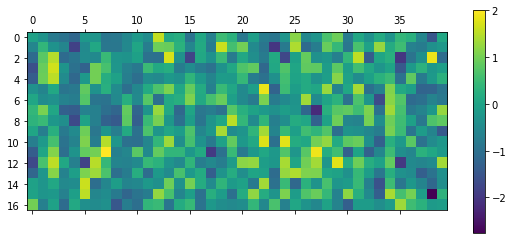

In [47]:
plt.matshow(x_dh)
plt.colorbar()

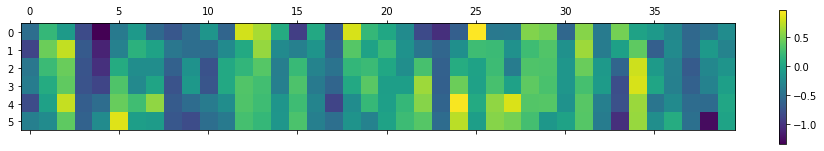

In [48]:
plt.matshow(x_dhe)
plt.colorbar()

In [58]:
x_op = feats_dict['27February_2011_Sunday_tagesschau_default-9'][56:85]
y_op = feats_dict['24August_2010_Tuesday_heute_default-7'][107:138]

In [59]:
x_ope = embedder.embed_segment(x_op).reshape(6,-1)
y_ope = embedder.embed_segment(y_op).reshape(6,-1)

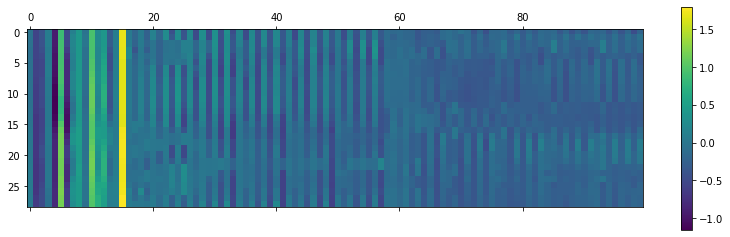

In [60]:
plt.matshow(x_op)
plt.colorbar()

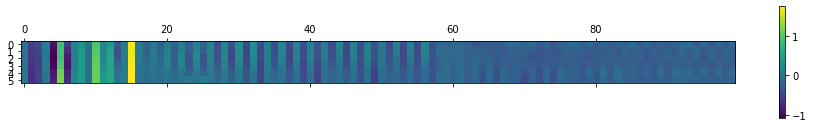

In [61]:
plt.matshow(x_ope)
plt.colorbar()

In [51]:
np.linalg.norm(x_dhe.reshape(-1) - y_dhe.reshape(-1))

8.489193184840254

In [57]:
np.linalg.norm(x_ope.reshape(-1) - y_ope.reshape(-1))

4.10504430598009

feat: pca40, {nopca} 47%  
feat: pca40, nopca 47  
feat: nopca, 52



In [ ]:
all_stats = dict()
tuners = dict()

for devset in sorted(cvsets):    
    testsets = sorted(cvsets - set(devset))
    
    # load related features
    params['CVset'] = devset
    seq_names = get_seq_names(params)
    feats_dict = load_feats(seq_names, params['featype'], params)
   
    # paramtune on devset
    print('=== Running Paramtune on Devset {} ==='.format(devset))
    tuner = TunerSkopt(seq_names, feats_dict, params)
#     tuner.prepare(load_checkpoint=True)
#     if devset == 'B':
    xopt, score_min = tuner.run(n_calls=15)
    tuners[devset] = tuner
    print('=== Paramtune completed with min score {} ==='.format(score_min))
    set_optim_params(params, xopt)
    
    # re-run to get full stats
    stats = [run_for_set(setx, load_feats, params) for setx in sorted(cvsets)]
    
    all_stats[devset] = stats

    # re-set params
    params = deepcopy(params_default)
    
    
# average dev, test scores

   

=== Running Paramtune on Devset A ===
Iteration No: 1 started. Searching for the next optimal point.
 === Running for new space {'lmax': 15, 'top_delta': 0.05} ===
knn_A_c3_right_PCA40_a3_dim_fix6_emb_typegauss_kernel_k150_lmax15_lmin2_metricL2_normFalse_olapthr_m0.5_pca_seg_typeuniform_top_delta0.05_use_gpuTrue_r0.07_s0.6
0.01
*** Matches already discovered !!! ***
*** found 73577 matches ***
*** post disc completed, found 852 segments from 426 clusters ***
*** Coverage: 0.3700, NED: 38.10
trial 0 th:0.01000 cov:0.37000 err:-14.63000
0.3851351351351351
*** Matches already discovered !!! ***
*** found 73577 matches ***
*** pairwise clustering ***
*** post disc completed, found 23408 segments from 11704 clusters ***
*** Coverage: 11.0000, NED: 53.35
trial 1 th:0.38514 cov:11.00000 err:-4.00000
0.5004812488876458
*** Matches already discovered !!! ***
*** found 73577 matches ***
*** pairwise clustering ***
*** post disc completed, found 31768 segments from 15884 clusters ***
*** Coverage

In [13]:
# res = tuners['A'].s
def top_n_results(res, n):
    return res.func_vals[np.argsort(res.func_vals)][:n], [res.x_iters[i] for i in np.argsort(res.func_vals)][:n]

In [ ]:
gbrt 

49.76 12, 12, 0.004111710628230209, 0.2341966457815864
44.34 14, 5, 0.17923047703889403, 0.4431
46.21 14, 10, 0.1880803340510649, 0.5945

gp

49.25 12, 12, 9.855643339381123e-05, 0.3148
43.11 15, 6, 0.16177853419464064, 0.3387
42.93 15, 5, 0.15589747266122583, 0.1

In [65]:
top_n_results(tuners['A'].result,15)

(array([ 50.44,  50.58,  50.66,  53.37,  54.94,  55.71,  57.87,  57.92,
         58.39, 100.  , 100.  , 100.  , 100.  ]),
 [[14, 0.03669668889112175],
  [14, 0.036904144194585424],
  [15, 0.041026118977886175],
  [18, 0.05939852077021734],
  [15, 0.05],
  [16, 0.05774801263571897],
  [12, 0.06207107783590824],
  [11, 0.05198197282067114],
  [11, 0.06775990178134599],
  [17, 0.024674783189293108],
  [14, 0.017997993265440233],
  [18, 0.010062301267281146],
  [15, 0.010565304417577392]])

In [64]:
top_n_results(tuners['B'].result,15)

(array([ 58.75,  58.83,  58.95,  60.87,  61.66,  62.14,  62.23,  62.89,
         62.91,  63.2 , 100.  , 100.  , 100.  , 100.  ]),
 [[14, 0.03685424067431726],
  [14, 0.03669668889112175],
  [14, 0.03698998356973769],
  [18, 0.05939852077021734],
  [15, 0.05],
  [16, 0.05774801263571897],
  [11, 0.04090525281928279],
  [11, 0.05198197282067114],
  [12, 0.06207107783590824],
  [11, 0.06775990178134599],
  [17, 0.024674783189293108],
  [14, 0.017997993265440233],
  [18, 0.010062301267281146],
  [15, 0.010565304417577392]])

In [63]:
top_n_results(tuners['C'].result,10)

(array([46.64, 46.95, 51.84, 53.85, 54.34, 54.95, 55.19, 56.01, 56.19,
        56.23]),
 [[18, 0.04093239647712639],
  [18, 0.04115653463208496],
  [14, 0.03669668889112175],
  [18, 0.05939852077021734],
  [15, 0.05],
  [16, 0.05774801263571897],
  [11, 0.040490585253597],
  [11, 0.05198197282067114],
  [18, 0.08820275779240082],
  [12, 0.06207107783590824]])

In [35]:
top_n_results(tuners['B'].result,30)

(array([ 49.14,  49.21,  49.46,  50.31,  52.72,  53.71,  58.19,  60.25,
         60.63,  62.45,  62.93,  63.13, 100.  , 100.  , 100.  , 100.  ]),
 [[4, 0.20991033932869546, 0.2999304858576278],
  [4, 0.2099017466407791, 0.28367420967181867],
  [4, 0.20859819147665346, 0.35724452937594253],
  [4, 0.19818934475962946, 0.6],
  [12, 0.1867056905362988, 0.5299702033681604],
  [9, 0.17833365530868367, 0.14998745790900148],
  [8, 0.13348411074699765, 0.17143340896097042],
  [4, 0.10390541783165663, 0.6],
  [10, 0.07337473251167567, 0.4898455001363847],
  [9, 0.022565575199261084, 0.4609993861334124],
  [12, 0.00031250555763989046, 0.5961057796456088],
  [10, 0.01, 0.4],
  [9, 0.24466165254215194, 0.10353315260985871],
  [4, 0.3895022337810649, 0.21638567021515215],
  [5, 0.24735478534722566, 0.29123099563358146],
  [4, 0.3158907772593369, 0.6]])

In [18]:
top_n_results(tuners['C'].result,30)

(array([ 42.06,  42.06,  42.06,  42.62,  42.81,  42.81,  43.03,  43.96,
         44.26,  44.41,  45.53,  45.56,  48.3 ,  48.39,  48.44,  48.48,
         49.71,  50.  ,  52.71,  53.54,  53.6 ,  53.63,  53.82,  53.9 ,
         54.13,  55.18,  55.26,  59.51, 100.  ]),
 [[15, 6, 0.2, 0.6],
  [15, 6, 0.2, 0.6],
  [15, 6, 0.2, 0.6],
  [15, 6, 0.2, 0.42272549403156356],
  [15, 5, 0.2, 0.6],
  [15, 5, 0.2, 0.6],
  [15, 8, 0.2, 0.6],
  [15, 6, 0.1898326368975767, 0.32761988840638145],
  [15, 6, 0.19478470237154918, 0.33729696593301545],
  [15, 6, 0.1972441493814063, 0.1390201817892224],
  [15, 6, 0.18081121366506103, 0.6],
  [15, 6, 0.19105923884551262, 0.1],
  [15, 6, 0.16379369835772906, 0.6],
  [15, 6, 0.16377317344031633, 0.6],
  [15, 6, 0.16243375254919803, 0.6],
  [15, 6, 0.16223673433974106, 0.5614202166211684],
  [15, 6, 0.15593842036355363, 0.39842507897324353],
  [15, 6, 0.15371897337578502, 0.3409880786134147],
  [6, 9, 0.07649301579144131, 0.5916154429033942],
  [5, 12, 0.1142009876

In [15]:
top_n_results(tuners['C'].result,30)

(array([ 41.01,  41.41,  41.77,  45.42,  45.87,  46.26,  46.35,  52.02,
         53.38,  53.58,  53.92,  53.95, 100.  ]),
 [[4, 0.20999408663648872, 0.6],
  [4, 0.20991033932869546, 0.2999304858576278],
  [4, 0.21954757979709058, 0.1],
  [9, 0.24466165254215194, 0.10353315260985871],
  [12, 0.1867056905362988, 0.5299702033681604],
  [9, 0.17833365530868367, 0.14998745790900148],
  [5, 0.24735478534722566, 0.29123099563358146],
  [8, 0.13348411074699765, 0.17143340896097042],
  [10, 0.07337473251167567, 0.4898455001363847],
  [12, 0.00031250555763989046, 0.5961057796456088],
  [10, 0.01, 0.4],
  [9, 0.022565575199261084, 0.4609993861334124],
  [4, 0.3895022337810649, 0.21638567021515215]])

In [17]:
dflist = []
for devset, stats in all_stats.items():
    dflist.append(pd.DataFrame([{**{'devset':devset},**{'set':key}, **item} 
                                for sublist in stats for key,item in sublist.items()]))
    
df = pd.concat(dflist, ignore_index=True)
df

,devset,set,ned,coverage,coverageNS,coverageNS_f,grouping_F,grouping_P,grouping_R,token_F,...,lmin,metric,norm,olapthr_m,pca,seg_type,top_delta,use_gpu,r,s
0,A,A,50.44,17.85,19.50,25.93,53.12,56.06,50.56,6.38,...,2,L2,False,0.5,,uniform,0.0367,True,0.07,0.6
1,A,Signer04,41.94,17.42,19.06,25.71,54.56,58.36,51.31,6.56,...,2,L2,False,0.5,,uniform,0.0500,True,0.07,0.6
2,A,Signer08,61.69,17.28,19.26,24.57,55.32,54.52,56.25,5.58,...,2,L2,False,0.5,,uniform,0.0500,True,0.07,0.6
3,A,Signer09,47.14,18.57,20.66,30.96,47.89,45.69,50.41,2.51,...,2,L2,False,0.5,,uniform,0.0500,True,0.07,0.6
4,A,B,62.11,18.33,19.62,27.31,56.70,56.60,56.91,5.84,...,2,L2,False,0.5,,uniform,0.0500,True,0.07,0.6
5,A,Signer02,63.68,17.20,19.61,31.64,43.48,45.12,42.05,3.38,...,2,L2,False,0.5,,uniform,0.0500,True,0.07,0.6
6,A,Signer05,60.48,18.08,19.64,26.44,58.18,59.15,57.33,5.70,...,2,L2,False,0.5,,uniform,0.0500,True,0.07,0.6
7,A,Signer07,61.14,19.40,20.50,29.03,44.75,42.31,47.60,5.41,...,2,L2,False,0.5,,uniform,0.0500,True,0.07,0.6
8,A,C,55.03,17.26,19.58,24.73,51.34,52.69,50.15,7.28,...,2,L2,False,0.5,,uniform,0.0500,True,0.07,0.6
9,A,Signer01,57.25,17.11,19.66,24.86,50.21,51.50,49.08,7.16,...,2,L2,False,0.5,,uniform,0.0500,True,0.07,0.6


In [11]:
df[['devset','set','lmin','lmax','dim_fix','r','s','ned']].style.background_gradient(cmap='Blues')

,devset,set,lmin,lmax,dim_fix,r,s,ned
0,A,A,2,15,6,0.073400,0.634800,50.120000
1,A,Signer04,2,15,6,0.073400,0.634800,39.840000
2,A,Signer08,2,15,6,0.073400,0.634800,61.340000
3,A,Signer09,2,15,6,0.073400,0.634800,46.080000
4,A,B,2,15,6,0.073400,0.634800,61.110000
5,A,Signer02,2,15,6,0.073400,0.634800,63.330000
6,A,Signer05,2,15,6,0.073400,0.634800,59.890000
7,A,Signer07,2,15,6,0.073400,0.634800,58.480000
8,A,C,2,15,6,0.073400,0.634800,54.290000
9,A,Signer01,2,15,6,0.073400,0.634800,56.670000


In [1]:
df[['devset','set','lmin','lmax','dim_fix','top_delta','r','s','ned']].style.background_gradient(cmap='Blues')

NameError: name 'df' is not defined

In [39]:
df[['devset','set','lmin','lmax','dim_fix','r','s','ned']].style.background_gradient(cmap='Blues')

,devset,set,lmin,lmax,dim_fix,r,s,ned
0,A,A,2.000000,5.000000,10.000000,0.010000,0.400000,49.940000
1,A,Signer04,2.000000,5.000000,10.000000,0.010000,0.400000,27.850000
2,A,Signer08,2.000000,5.000000,10.000000,0.010000,0.400000,61.780000
3,A,Signer09,2.000000,5.000000,10.000000,0.010000,0.400000,43.270000
4,A,B,2.000000,5.000000,10.000000,0.010000,0.400000,62.720000
5,A,Signer02,2.000000,5.000000,10.000000,0.010000,0.400000,75.000000
6,A,Signer05,2.000000,5.000000,10.000000,0.010000,0.400000,60.640000
7,A,Signer07,2.000000,5.000000,10.000000,0.010000,0.400000,58.870000
8,A,C,2.000000,5.000000,10.000000,0.010000,0.400000,53.390000
9,A,Signer01,2.000000,5.000000,10.000000,0.010000,0.400000,54.350000


In [16]:
df.columns

Index(['devset', 'set', 'ned', 'coverage', 'coverageNS', 'coverageNS_f',
       'grouping_F', 'grouping_P', 'grouping_R', 'token_F', 'token_P',
       'token_R', 'type_F', 'type_P', 'type_R', 'boundary_F', 'boundary_P',
       'boundary_R', 'n_clus', 'n_node', 'exp_path', 'length_avg', 'a',
       'dim_fix', 'emb_type', 'k', 'lmax', 'lmin', 'metric', 'norm',
       'olapthr_m', 'pca', 'seg_type', 'top_delta', 'use_gpu', 'r', 's'],
      dtype='object')

In [18]:
dfname = '../results/cv/{}_{}_l6_{}_cov20.csv'.format(params['disc_method'], params['featype'], '_'.join(params['tune']['keys']))
dfname

'../results/cv/knn_c3_right_PCA40_l6_lmax_top_delta_cov20.csv'

In [19]:
df.to_csv(dfname)

In [38]:
tuners['A']._plot()

AttributeError: 'TunerSkopt' object has no attribute 'result'

In [106]:
for setx in ['A']:
    signers = ['Signer0{}'.format(x) for x in signers_per_set[setx]]
    print(signers)

['Signer04', 'Signer08', 'Signer09']


In [74]:
for i, key in enumerate(params['tune']['keys']):
    print(i,key)

0 r
1 s


In [80]:
set_optim_params(params, xopt)

In [114]:
sorted(cvsets)

['A0', 'B', 'C']

In [17]:
import glob
from utils.helper_fncs import load_obj2

In [37]:
expdir = glob.glob('../../Desktop/tez/knn_exps/knn_A_c3_right_a4_dim_fix2_emb_typegauss_kernel_k108_lmax28_lmin4_metricL2_normFalse_olapthr_m0.25_pca_seg_typeuniform_top_delta0.015390222152996708_use_gpuTrue_r0.2892313182057481_s0.8199165393270312/postpairwise_cost0.4410549776573912_olap0.1/*')

In [71]:
expdir = glob.glob('../../Desktop/tez/knn_exps/knn_A_c3_right_a4_dim_fix10_emb_typegauss_kernel_k102_lmax28_lmin4_metricL2_normFalse_olapthr_m0.25_pca_seg_typeuniform_top_delta0.01_use_gpuTrue_r0.0001_s0.43/postpairwise_cost0.5883693270735523_olap0.25/*')

In [21]:
expdir = glob.glob(df.exp_path[0] + '/*')

In [22]:
expdir

['/home/korhan/Desktop/tez/knn_exps/knn_A_c3_right_PCA40_a3_dim_fix10_emb_typegauss_kernel_k150_lmax5_lmin2_metricL2_normFalse_olapthr_m0.1_pca_seg_typeuniform_top_delta0.04_use_gpuTrue_r0.01_s0.4/postpairwise_cost0.19716485422896887_olap0.1/clusters_tde.json',
 '/home/korhan/Desktop/tez/knn_exps/knn_A_c3_right_PCA40_a3_dim_fix10_emb_typegauss_kernel_k150_lmax5_lmin2_metricL2_normFalse_olapthr_m0.1_pca_seg_typeuniform_top_delta0.04_use_gpuTrue_r0.01_s0.4/postpairwise_cost0.19716485422896887_olap0.1/scores.json',
 '/home/korhan/Desktop/tez/knn_exps/knn_A_c3_right_PCA40_a3_dim_fix10_emb_typegauss_kernel_k150_lmax5_lmin2_metricL2_normFalse_olapthr_m0.1_pca_seg_typeuniform_top_delta0.04_use_gpuTrue_r0.01_s0.4/postpairwise_cost0.19716485422896887_olap0.1/clusters.pkl',
 '/home/korhan/Desktop/tez/knn_exps/knn_A_c3_right_PCA40_a3_dim_fix10_emb_typegauss_kernel_k150_lmax5_lmin2_metricL2_normFalse_olapthr_m0.1_pca_seg_typeuniform_top_delta0.04_use_gpuTrue_r0.01_s0.4/postpairwise_cost0.197164854

In [23]:
load_json(expdir[1])

{'ned': 49.94,
 'coverage': 9.08,
 'coverageNS': 9.85,
 'coverageNS_f': 11.85,
 'grouping_F': 49.12,
 'grouping_P': 61.76,
 'grouping_R': 40.83,
 'token_F': 5.29,
 'token_P': 18.39,
 'token_R': 3.09,
 'type_F': 20.6,
 'type_P': 41.49,
 'type_R': 13.7,
 'boundary_F': 26.29,
 'boundary_P': 100.0,
 'boundary_R': 15.15,
 'n_clus': 1713,
 'n_node': 3426,
 'exp_path': '/home/korhan/Desktop/tez/knn_exps/knn_A_c3_right_PCA40_a3_dim_fix10_emb_typegauss_kernel_k150_lmax5_lmin2_metricL2_normFalse_olapthr_m0.1_pca_seg_typeuniform_top_delta0.04_use_gpuTrue_r0.01_s0.4/postpairwise_cost0.19716485422896887_olap0.1'}

In [14]:
load_json(expdir[1])

{'ned': 44.330000000000005,
 'coverage': 13.43,
 'coverageNS': 11.97,
 'coverageNS_f': 7.68,
 'grouping_F': 32.23,
 'grouping_P': 41.75,
 'grouping_R': 26.3,
 'token_F': 8.09,
 'token_P': 21.18,
 'token_R': 5.0,
 'type_F': 27.57,
 'type_P': 35.33,
 'type_R': 22.6,
 'boundary_F': 18.96,
 'boundary_P': 41.260000000000005,
 'boundary_R': 12.34,
 'n_clus': 4957,
 'n_node': 9914,
 'exp_path': '/home/korhan/Desktop/tez/knn_exps/knn_A_c3_right_a4_dim_fix10_emb_typegauss_kernel_k106_lmax28_lmin4_metricL2_normFalse_olapthr_m0.25_pca_seg_typeuniform_top_delta0.01_use_gpuTrue_r0.001_s0.43/postpairwise_cost0.44444444444444453_olap0.1'}

In [24]:
clusters_tde = load_json(expdir[0])
len(clusters_tde)

1713

In [41]:
len(set(clus[0][-1]) & set(clus[1][-1]))

NameError: name 'clus' is not defined

In [25]:
clusters_tde

{'200': [['06January_2011_Thursday_tagesschau_default-5',
   84.0,
   93.0,
   [[81.0, 89.0, '__OFF__']],
   ['__OFF__']],
  ['21April_2010_Wednesday_heute_default-3',
   30.0,
   36.0,
   [[32.0, 40.0, '__ON__']],
   ['__ON__']]],
 '213': [['06January_2011_Thursday_tagesschau_default-5',
   84.0,
   90.0,
   [[81.0, 89.0, '__OFF__']],
   ['__OFF__']],
  ['06January_2011_Thursday_tagesschau_default-5',
   90.0,
   96.0,
   [[89.0, 100.0, '__ON__']],
   ['__ON__']]],
 '256': [['21November_2009_Saturday_tagesschau_default-0',
   39.0,
   48.0,
   [[42.0, 52.0, 'MORGEN']],
   ['MORGEN']],
  ['22October_2009_Thursday_tagesschau_default-0',
   54.0,
   63.0,
   [[56.0, 68.0, 'MORGEN']],
   ['MORGEN']]],
 '287': [['18February_2010_Thursday_tagesschau_default-0',
   39.0,
   45.0,
   [[38.0, 48.0, 'MORGEN']],
   ['MORGEN']],
  ['22October_2009_Thursday_tagesschau_default-0',
   57.0,
   63.0,
   [[56.0, 68.0, 'MORGEN']],
   ['MORGEN']]],
 '361': [['06March_2011_Sunday_tagesschau_default-0',
 

In [26]:
for idx, clus in clusters_tde.items():
    common = set(clus[0][-1]) & set(clus[1][-1])
    if len(common) > 0:
        print(common)

{'MORGEN'}
{'MORGEN'}
{'MONTAG'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MONTAG'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MONTAG'}
{'FROST'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'__OFF__'}
{'KUEHL'}
{'MONTAG'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'KUEHL'}
{'WIE-AUSSEHEN'}
{'FROST'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MONTAG'}
{'MORGEN'}
{'KOENNEN'}
{'MORGEN'}
{'MORGEN'}
{'KOENNEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'KUEHL'}
{'MORGEN'}
{'MORGEN'}
{'STURM'}
{'__OFF__'}
{'KUEHL'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'WIE-AUSSEHEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'KOENNEN'}
{'NORD'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'KUEHL'}
{'WIND'}
{'MONTAG'}
{'MORGEN'}
{'WIE-AUSSEHEN'}
{'WIE-AUSSEHEN'}
{'MORGEN'}
{'MORGEN'}
{'NORD'}
{'MORGEN'}
{'MONTAG'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'WIE-AUSSEHEN'}
{'MORGEN'}
{'WIE-AUSSEHEN'}
{'MORGEN'}
{'NORD'}
{'MORGE

In [23]:
clus[0][0] == clus[1][0]

False

In [23]:
clusters = load_obj2(expdir[2])

In [24]:
len(clusters)

19400

In [25]:
from itertools import combinations


In [59]:
for i,j in combinations([1],2):
    print(i,j)

In [ ]:
# for each fold collect these stats
# dev set: [signer_ids], n_seq: , param_opt: scores@min: test set: 


### prepare results

In [29]:
nfolder_persigner = [1475,
                    49,
                    470,
                    836,
                    1296,
                    30,
                    646,
                    704,
                    165]

report_cols = ['ned','length_avg', 'n_clus', 'n_node',
              'grouping_P', 'grouping_R', 'grouping_F', 
              'nfile']

signers_per_set = {'A': [4,8,9], 'B':[2,5,7], 'C':[1,3,6]}

In [30]:
nfolder_perset = dict()
for devset in ['A','B','C']:
    nfolder_perset[devset] = 0
    for i in signers_per_set[devset]:
        key = 'Signer0{}'.format(i) 
        nfolder_perset[key] = nfolder_persigner[i-1]
        nfolder_perset[devset] += nfolder_persigner[i-1]
nfolder_perset

{'A': 1705,
 'Signer04': 836,
 'Signer08': 704,
 'Signer09': 165,
 'B': 1991,
 'Signer02': 49,
 'Signer05': 1296,
 'Signer07': 646,
 'C': 1975,
 'Signer01': 1475,
 'Signer03': 470,
 'Signer06': 30}

In [100]:
df = pd.read_csv('../results/cv/knn_c3_right_PCA40_l6-45_dim_fix_r_s.csv')
# df = pd.read_csv('../results/cv/knn_op100_l6_lmax_dim_fix_r_s.csv')
df = pd.read_csv('../results/cv/zr_cat_c3_right_PCA40_T_dx_castthr.csv')
df

,Unnamed: 0,devset,set,ned,coverage,coverageNS,coverageNS_f,grouping_F,grouping_P,grouping_R,...,R,T,Tscore,castthr,dx,dy,medthr,rhothr,trimthr,n_concat
0,0,A,A,41.39,9.50,9.51,13.35,23.16,16.32,40.16,...,15.0,0.3663,0.5,7.0599,29.0,5.0,0.45,0.0,1.0,20.0
1,1,A,Signer04,35.56,9.27,9.08,11.52,25.79,19.06,40.09,...,15.0,0.3663,0.5,7.0599,29.0,5.0,0.45,0.0,1.0,20.0
2,2,A,Signer08,44.34,10.12,9.93,13.00,25.04,15.83,60.27,...,15.0,0.3663,0.5,7.0599,29.0,5.0,0.45,0.0,1.0,20.0
3,3,A,Signer09,51.56,10.48,10.36,15.27,4.74,2.82,15.38,...,15.0,0.3663,0.5,7.0599,29.0,5.0,0.45,0.0,1.0,20.0
4,4,A,B,47.19,9.41,9.16,12.07,23.62,15.07,54.98,...,15.0,0.3663,0.5,7.0599,29.0,5.0,0.45,0.0,1.0,20.0
5,5,A,Signer02,100.00,NaN,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,A,Signer05,47.59,9.49,9.37,11.58,27.26,16.97,69.67,...,15.0,0.3663,0.5,7.0599,29.0,5.0,0.45,0.0,1.0,20.0
7,7,A,Signer07,100.00,NaN,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,A,C,32.94,9.73,9.67,12.62,28.38,18.85,57.66,...,15.0,0.3663,0.5,7.0599,29.0,5.0,0.45,0.0,1.0,20.0
9,9,A,Signer01,39.32,10.13,9.99,12.97,24.85,16.16,54.04,...,15.0,0.3663,0.5,7.0599,29.0,5.0,0.45,0.0,1.0,20.0


In [101]:
df.drop(columns=['pca'], inplace=True)

KeyError: "['pca'] not found in axis"

In [102]:
df.dropna(inplace=True)

In [103]:
df.columns

Index(['Unnamed: 0', 'devset', 'set', 'ned', 'coverage', 'coverageNS',
       'coverageNS_f', 'grouping_F', 'grouping_P', 'grouping_R', 'token_F',
       'token_P', 'token_R', 'type_F', 'type_P', 'type_R', 'boundary_F',
       'boundary_P', 'boundary_R', 'n_clus', 'n_node', 'exp_path',
       'length_avg', 'B', 'D', 'P', 'R', 'T', 'Tscore', 'castthr', 'dx', 'dy',
       'medthr', 'rhothr', 'trimthr', 'n_concat'],
      dtype='object')

In [104]:
df[['devset', 'set', 'ned', 'coverage', 'T', 'dx', 'medthr', 'castthr', ]]

,devset,set,ned,coverage,T,dx,medthr,castthr
0,A,A,41.39,9.50,0.3663,29.0,0.45,7.0599
1,A,Signer04,35.56,9.27,0.3663,29.0,0.45,7.0599
2,A,Signer08,44.34,10.12,0.3663,29.0,0.45,7.0599
3,A,Signer09,51.56,10.48,0.3663,29.0,0.45,7.0599
4,A,B,47.19,9.41,0.3663,29.0,0.45,7.0599
6,A,Signer05,47.59,9.49,0.3663,29.0,0.45,7.0599
8,A,C,32.94,9.73,0.3663,29.0,0.45,7.0599
9,A,Signer01,39.32,10.13,0.3663,29.0,0.45,7.0599
10,A,Signer03,21.77,9.40,0.3663,29.0,0.45,7.0599
12,B,A,41.39,9.50,0.3663,29.0,0.45,7.0599


In [92]:
df[['devset', 'set', 'ned', 'coverage', 'lmax', 'dim_fix', 'r', 's']]

,devset,set,ned,coverage,lmax,dim_fix,r,s
0,A,A,37.59,8.52,15,4,0.2100,0.6
1,A,Signer04,29.40,8.29,15,4,0.2100,0.6
2,A,Signer08,55.71,9.13,15,4,0.2100,0.6
3,A,Signer09,37.78,8.86,15,4,0.2100,0.6
4,A,B,43.99,9.74,15,4,0.2100,0.6
5,A,Signer02,62.82,8.37,15,4,0.2100,0.6
6,A,Signer05,54.98,8.81,15,4,0.2100,0.6
7,A,Signer07,52.12,9.07,15,4,0.2100,0.6
8,A,C,41.08,8.65,15,4,0.2100,0.6
9,A,Signer01,44.53,8.65,15,4,0.2100,0.6


In [93]:
df['nfile'] = df.set.apply(lambda x: nfolder_perset[x])
# df[['devset','set','medthr','dx','castthr','ned','exp_path']]

In [94]:
df

,Unnamed: 0,devset,set,ned,coverage,coverageNS,coverageNS_f,grouping_F,grouping_P,grouping_R,...,lmin,metric,norm,olapthr_m,seg_type,top_delta,use_gpu,r,s,nfile
0,0,A,A,37.59,8.52,9.32,11.62,54.36,53.19,55.68,...,2,L2,False,0.2,uniform,0.05,True,0.2100,0.6,1705
1,1,A,Signer04,29.40,8.29,9.10,11.99,57.51,58.28,56.84,...,2,L2,False,0.2,uniform,0.06,True,0.2100,0.6,836
2,2,A,Signer08,55.71,9.13,10.19,12.06,47.78,43.59,52.99,...,2,L2,False,0.2,uniform,0.05,True,0.2100,0.6,704
3,3,A,Signer09,37.78,8.86,9.68,13.42,53.15,47.37,60.67,...,2,L2,False,0.2,uniform,0.06,True,0.2100,0.6,165
4,4,A,B,43.99,9.74,10.45,14.28,53.77,52.14,55.62,...,2,L2,False,0.2,uniform,0.05,True,0.2100,0.6,1991
5,5,A,Signer02,62.82,8.37,9.32,16.65,42.20,38.46,46.88,...,2,L2,False,0.2,uniform,0.09,True,0.2100,0.6,49
6,6,A,Signer05,54.98,8.81,9.60,13.11,48.27,46.53,50.25,...,2,L2,False,0.2,uniform,0.05,True,0.2100,0.6,1296
7,7,A,Signer07,52.12,9.07,9.56,13.29,40.31,35.41,46.90,...,2,L2,False,0.2,uniform,0.07,True,0.2100,0.6,646
8,8,A,C,41.08,8.65,9.83,12.15,49.73,48.19,51.47,...,2,L2,False,0.2,uniform,0.05,True,0.2100,0.6,1975
9,9,A,Signer01,44.53,8.65,9.96,12.33,48.52,47.16,50.05,...,2,L2,False,0.2,uniform,0.05,True,0.2100,0.6,1475


In [95]:
devs_ms = []
devs_si = []
tests_ms = []
tests_si = []


In [96]:
for devset in ['A','B','C']:
    dev_signers = ['Signer0{}'.format(i) for i in signers_per_set[devset]]

    fold_df = df.loc[df.devset.isin([devset])]
    dev_df = fold_df.loc[fold_df.set.isin([devset]+dev_signers)][report_cols+['set']]
    test_df = fold_df.loc[~fold_df.set.isin([devset]+dev_signers)][report_cols+['set']]

    fold = dev_df
    fold_sd = fold.loc[[len(x)>1 for x in fold.set]]
    fold_ms = fold.loc[[len(x)==1 for x in fold.set]]
    tmp = pd.DataFrame(((fold_sd[report_cols].values * fold_sd.nfile.values[:,None]).sum(0) / fold_sd.nfile.sum())[None,:],
             columns=report_cols)
    
    devs_ms.append(fold_ms)
    devs_si.append(tmp)
    
    fold = test_df
    fold_sd = fold.loc[[len(x)>1 for x in fold.set]]
    fold_ms = fold.loc[[len(x)==1 for x in fold.set]]
    tmp = pd.DataFrame(((fold_sd[report_cols].values * fold_sd.nfile.values[:,None]).sum(0) / fold_sd.nfile.sum())[None,:],
             columns=report_cols)
    
    tests_ms.append(fold_ms)
    tests_si.append(tmp)


In [97]:
def averege(df_list):
    fold_sd = pd.concat(df_list)
    tmp = pd.DataFrame(((fold_sd[report_cols].values * fold_sd.nfile.values[:,None]).sum(0) / fold_sd.nfile.sum())[None,:],
                 columns=report_cols)
    return tmp

In [98]:
keys = ['Dev MS' , 'Dev SD' ,'Test MS' ,'Test SD']

final = []

for k,df_list in enumerate([devs_ms , devs_si ,tests_ms ,tests_si ]):
    avg_df = averege(df_list)
    avg_df['exp'] = keys[k]
    
    final.append(avg_df)
    
    display(avg_df)

,ned,length_avg,n_clus,n_node,grouping_P,grouping_R,grouping_F,nfile,exp
0,41.394225,12.802079,1279.876918,2559.753835,50.82115,52.825569,51.753597,1899.441192,Dev MS


,ned,length_avg,n_clus,n_node,grouping_P,grouping_R,grouping_F,nfile,exp
0,46.117081,12.601769,611.901816,1223.803631,47.004144,50.726558,48.663024,1038.160623,Dev SD


,ned,length_avg,n_clus,n_node,grouping_P,grouping_R,grouping_F,nfile,exp
0,43.36996,12.917961,1359.21513,2718.430259,50.093738,52.044981,50.992494,1899.441192,Test MS


,ned,length_avg,n_clus,n_node,grouping_P,grouping_R,grouping_F,nfile,exp
0,47.190062,12.793111,609.068594,1218.137187,46.619867,50.579391,48.347928,1014.697782,Test SD


In [99]:
findf = pd.concat(final)[['exp'] + report_cols]
# findf[['grouping_P','grouping_R','grouping_F','ned']] *= 100
findf

,exp,ned,length_avg,n_clus,n_node,grouping_P,grouping_R,grouping_F,nfile
0,Dev MS,41.394225,12.802079,1279.876918,2559.753835,50.821150,52.825569,51.753597,1899.441192
0,Dev SD,46.117081,12.601769,611.901816,1223.803631,47.004144,50.726558,48.663024,1038.160623
0,Test MS,43.369960,12.917961,1359.215130,2718.430259,50.093738,52.044981,50.992494,1899.441192
0,Test SD,47.190062,12.793111,609.068594,1218.137187,46.619867,50.579391,48.347928,1014.697782


In [59]:
tmp = pd.DataFrame(((fold_sd[report_cols].values * fold_sd.nfile.values[:,None]).sum(0) / fold_sd.nfile.sum())[None,:],
             columns=report_cols)
tmp

,ned,length_avg,n_clus,n_node,grouping_P,grouping_R,grouping_F,nfile
0,0.499933,5.254748,3533.651613,4662.025806,0.375534,0.205467,0.260447,716.56129
